# Create FTK plots from new FTKxAODReader output

pip install numpy root_numpy rootpy matplotlib

In [1]:
%matplotlib inline

In [81]:
import numpy as np
from matplotlib import pyplot as plt
from rootpy.io import root_open
from rootpy.plotting import Canvas, Hist, Legend, set_style
from rootpy.plotting.utils import draw
from root_numpy import root2array, tree2array, fill_hist, stretch
set_style('ATLAS')

INFO:rootpy.plotting.style:using ROOT style 'ATLAS'


In [3]:
def efficiency(arr, match_condition, hist):
    # Return an efficiency histogram using an array of values
    # with some matching condition w.r.t. the array without the condition
    total = hist.Clone()
    fill_hist(total, arr)
    reco = hist.Clone()
    fill_hist(reco, arr[match_condition])
    return reco / total

In [4]:
# read in an array for efficiency plotting
branches = [
    'truth_track_pt', 'truth_track_eta', 'truth_track_d0',
    'truth_track_reco_match', 'truth_track_ftk_match', 'truth_track_ftk_refit_match',
]
arr = root2array('tracks.root', 'tracks', branches=branches,
                 selection='abs(truth_track_d0) < 2 && '
                           'abs(truth_track_z0) < 110 && '
                           'abs(truth_track_eta) < 2.5 && '
                           'truth_track_barcode > 0 && truth_track_barcode <= 100000 && '
                           'abs(truth_track_qop * .5) < .5 && '
                           'truth_track_prod_perp < 40')
arr_flat = stretch(arr) # convert array of events to array of tracks

## Efficiency with respect to truth-level $p_{T}$

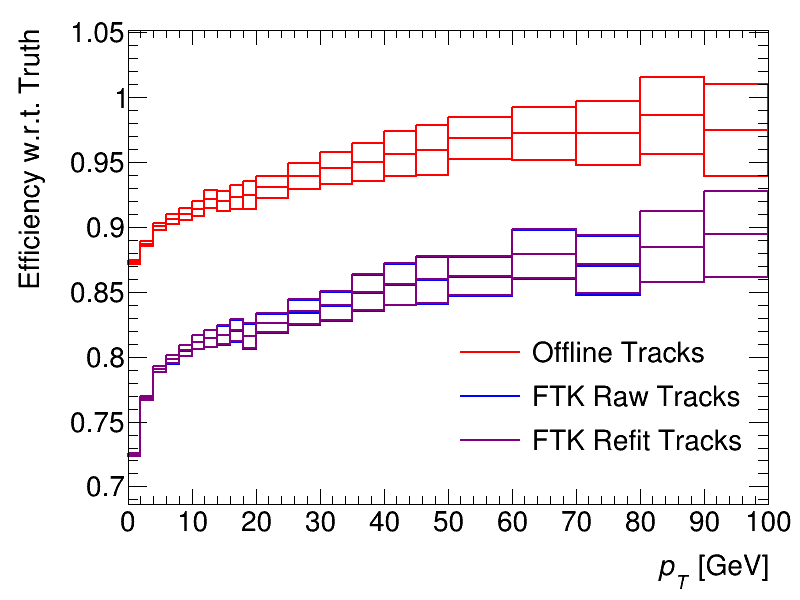

In [5]:
bins = np.array([0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100]) # same as TrigFTKSim's efficiency.cc
eff_off = efficiency(arr_flat['truth_track_pt'], arr_flat['truth_track_reco_match'] > -1,
                     Hist(bins, drawstyle='hist e2', linecolor='red', markersize=0,
                          linewidth=2, legendstyle='L', title="Offline Tracks"))
eff_ftk = efficiency(arr_flat['truth_track_pt'], arr_flat['truth_track_ftk_match'] > -1,
                     Hist(bins, drawstyle='hist e2', linecolor='blue', markersize=0,
                          linewidth=2, legendstyle='L', title="FTK Raw Tracks"))
eff_ftk_refit = efficiency(arr_flat['truth_track_pt'], arr_flat['truth_track_ftk_refit_match'] > -1,
                           Hist(bins, drawstyle='hist e2', linecolor='purple', markersize=0,
                                linewidth=2, legendstyle='L', title="FTK Refit Tracks"))
canvas = Canvas()
draw([eff_off, eff_ftk, eff_ftk_refit], pad=canvas, snap=False,
     xtitle='#font[52]{p_{T}} [GeV]', ytitle='Efficiency w.r.t. Truth')
leg = Legend([eff_off, eff_ftk, eff_ftk_refit], pad=canvas, topmargin=0.5, leftmargin=0.4)
leg.Draw()
canvas

## Efficiency with respect to truth-level $\eta$

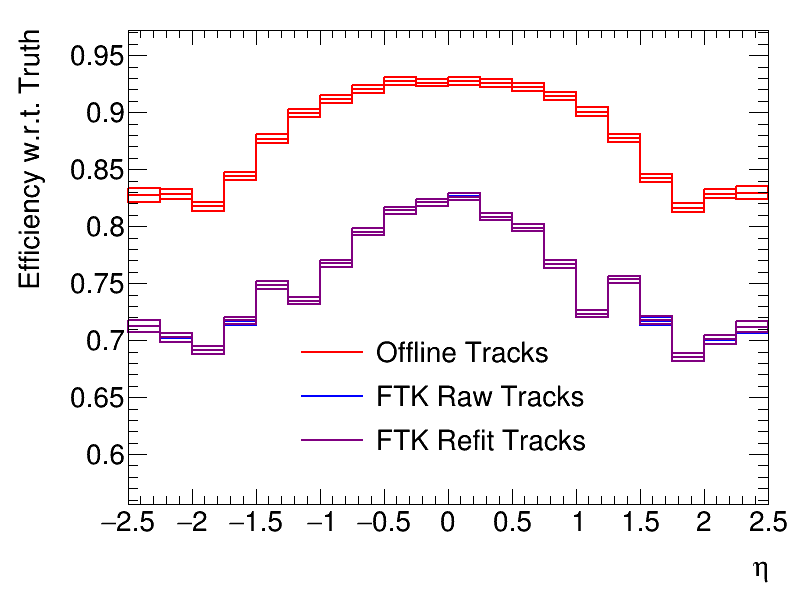

In [6]:
eff_off = efficiency(arr_flat['truth_track_eta'], arr_flat['truth_track_reco_match'] > -1, 
                     Hist(20, -2.5, 2.5, drawstyle="HIST e2", legendstyle="L", markersize=0,
                          linecolor='red', linewidth=2, title="Offline Tracks"))
eff_ftk = efficiency(arr_flat['truth_track_eta'], arr_flat['truth_track_ftk_match'] > -1,
                     Hist(20, -2.5, 2.5, drawstyle="HIST e2", legendstyle="L", markersize=0,
                          linecolor="blue", linewidth=2, title="FTK Raw Tracks"))
eff_ftk_refit = efficiency(arr_flat['truth_track_eta'], arr_flat['truth_track_ftk_refit_match'] > -1,
                           Hist(20, -2.5, 2.5, drawstyle="HIST e2", legendstyle="L", markersize=0,
                                linecolor="purple", linewidth=2, title="FTK Refit Tracks"))
canvas = Canvas()
draw([eff_off, eff_ftk, eff_ftk_refit], pad=canvas, snap=False,
     xtitle='#font[152]{#eta}', ytitle='Efficiency w.r.t. Truth', ypadding=(0.1, 0.3))
leg = Legend([eff_off, eff_ftk, eff_ftk_refit], pad=canvas, topmargin=0.5, leftmargin=0.2, margin=0.2)
leg.Draw()
canvas

## Plot track parameter resolutions

In [49]:
ftk_branches = [
    'ftk_track_pt', 'ftk_track_d0',
    'ftk_refit_track_pt', 'ftk_refit_track_d0',
]
arr_ftk_flat = stretch(root2array('tracks.root', 'tracks', branches=ftk_branches))

idx_branches = [
    'truth_track_reco_match', 'truth_track_ftk_match', 'truth_track_ftk_refit_match',
]
arr_idx = stretch(root2array('tracks.root', 'tracks', branches=idx_branches))

truth_branches = ['truth_track_pt', 'truth_track_eta', 'truth_track_d0']
arr_truth_flat = stretch(root2array('tracks.root', 'tracks', branches=truth_branches))

reco_branches = ['reco_track_pt', 'reco_track_d0']
arr_reco_flat = stretch(root2array('tracks.root', 'tracks', branches=reco_branches))

In [62]:
# stretch match indices to account for index offsets after each event
num_tracks = root2array('tracks.root', 'tracks',
                        branches=['truth_track_n', 'ftk_track_n', 'ftk_refit_track_n', 'reco_track_n'])
ftk_track_idx_offset = np.pad(np.repeat(np.cumsum(num_tracks['ftk_track_n'][:-1]), num_tracks['truth_track_n'][1:]),
                              (num_tracks['truth_track_n'][0], 0), 'constant', constant_values=(0,))
ftk_refit_track_idx_offset = np.pad(
    np.repeat(np.cumsum(num_tracks['ftk_refit_track_n'][:-1]), num_tracks['truth_track_n'][1:]),
                        (num_tracks['truth_track_n'][0], 0), 'constant', constant_values=(0,))
reco_track_idx_offset = np.pad(np.repeat(np.cumsum(num_tracks['reco_track_n'][:-1]), num_tracks['truth_track_n'][1:]),
                              (num_tracks['truth_track_n'][0], 0), 'constant', constant_values=(0,))

truth_ftk_idx = np.copy(arr_idx['truth_track_ftk_match'])
truth_ftk_idx[arr_idx['truth_track_ftk_match'] > -1] += ftk_track_idx_offset[arr_idx['truth_track_ftk_match'] > -1]

truth_ftk_refit_idx = np.copy(arr_idx['truth_track_ftk_refit_match'])
truth_ftk_refit_idx[arr_idx['truth_track_ftk_refit_match'] > -1] += ftk_refit_track_idx_offset[arr_idx['truth_track_ftk_refit_match'] > -1]

truth_reco_idx = np.copy(arr_idx['truth_track_reco_match'])
truth_reco_idx[arr_idx['truth_track_reco_match'] > -1] += reco_track_idx_offset[arr_idx['truth_track_reco_match'] > -1]

print truth_ftk_idx.shape
print truth_ftk_refit_idx.shape
print truth_reco_idx.shape

(2415090,)
(2415090,)
(2415090,)


In [45]:
res_d0 = arr_truth_flat['truth_track_d0'][truth_ftk_refit_idx > -1] - np.take(
    arr_ftk_flat['ftk_refit_track_d0'], truth_ftk_refit_idx[truth_ftk_refit_idx > -1])
res_d0_hist = Hist(100, -0.2, 0.2)
fill_hist(res_d0_hist, res_d0)
canvas = Canvas()
draw([res_d0_hist], pad=canvas,
     xtitle='\Delta d_{0} \;\;\; (Truth - Refit) \;\;\; [mm]', ytitle='Tracks')
canvas

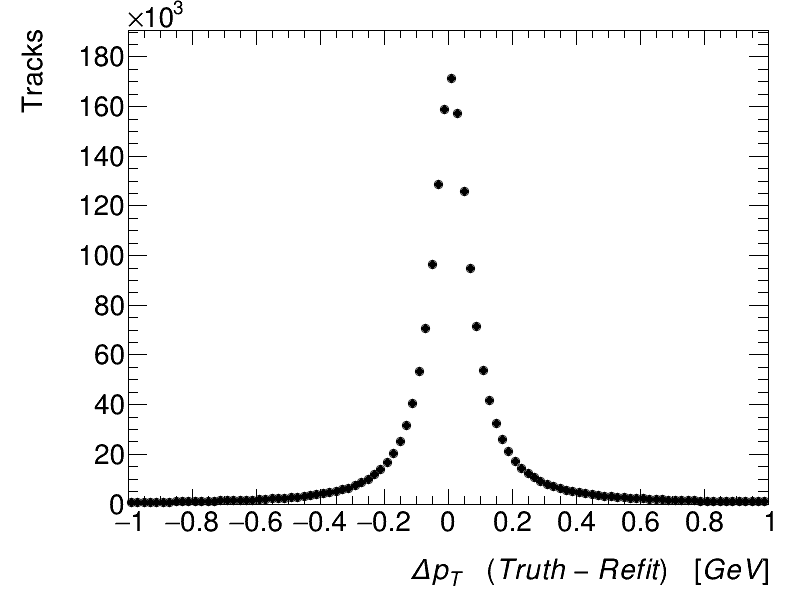

In [46]:
res_pt = arr_truth_flat['truth_track_pt'][truth_ftk_refit_idx > -1] - np.take(
    arr_ftk_flat['ftk_refit_track_pt'], truth_ftk_refit_idx[truth_ftk_refit_idx > -1]) / 1000.
res_pt_hist = Hist(100, -1, 1)
fill_hist(res_pt_hist, res_pt)
canvas = Canvas()
draw([res_pt_hist], pad=canvas,
     xtitle='\Delta p_{T} \;\;\; (Truth - Refit) \;\;\; [GeV]', ytitle='Tracks')
canvas

## Plot difference between truth-matched FTK and offline tracks

In [73]:
idx_truth_both_match = np.where(
    (arr_idx['truth_track_ftk_refit_match'] > -1) & (arr_idx['truth_track_reco_match'] > -1))[0]

idx_ftk = truth_ftk_refit_idx[idx_truth_both_match]
idx_reco = truth_reco_idx[idx_truth_both_match]

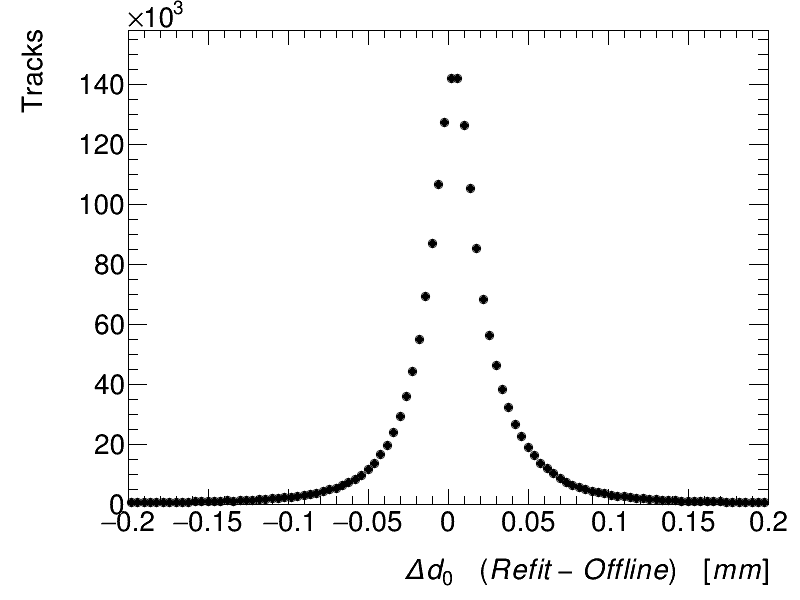

In [75]:
delta_d0 = arr_ftk_flat['ftk_refit_track_d0'][idx_ftk] - arr_reco_flat['reco_track_d0'][idx_reco]
delta_d0_hist = Hist(100, -0.2, 0.2)
fill_hist(delta_d0_hist, delta_d0)
canvas = Canvas()
draw([delta_d0_hist], pad=canvas,
     xtitle='\Delta d_{0} \;\;\; (Refit - Offline) \;\;\; [mm]', ytitle='Tracks')
canvas

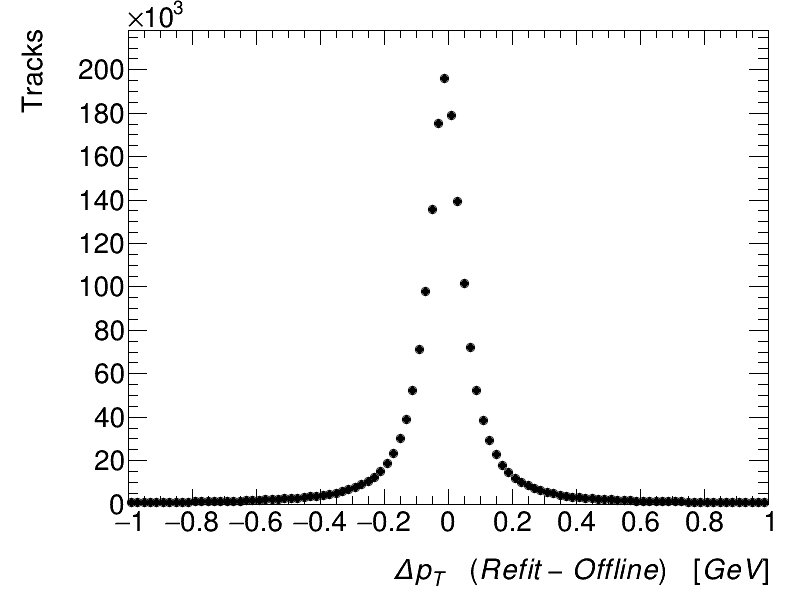

In [80]:
delta_pt = arr_ftk_flat['ftk_refit_track_pt'][idx_ftk] - arr_reco_flat['reco_track_pt'][idx_reco]
delta_pt_hist = Hist(100, -1, 1)
fill_hist(delta_pt_hist, delta_pt / 1000.)
canvas = Canvas()
draw([delta_pt_hist], pad=canvas,
     xtitle='\Delta p_{T} \;\;\; (Refit - Offline) \;\;\; [GeV]', ytitle='Tracks')
canvas

## Plot difference between raw and refit track parameters

In [14]:
hist_d0 = Hist(100, -0.2, 0.2)
hist_z0 = Hist(100, -2, 2)
delta_d0 = arr_ftk_flat['ftk_refit_track_d0'] - arr_ftk_flat['ftk_track_d0']
delta_z0 = arr_ftk_flat['ftk_refit_track_z0'] - arr_ftk_flat['ftk_track_z0']
fill_hist(hist_d0, delta_d0)
fill_hist(hist_z0, delta_z0)

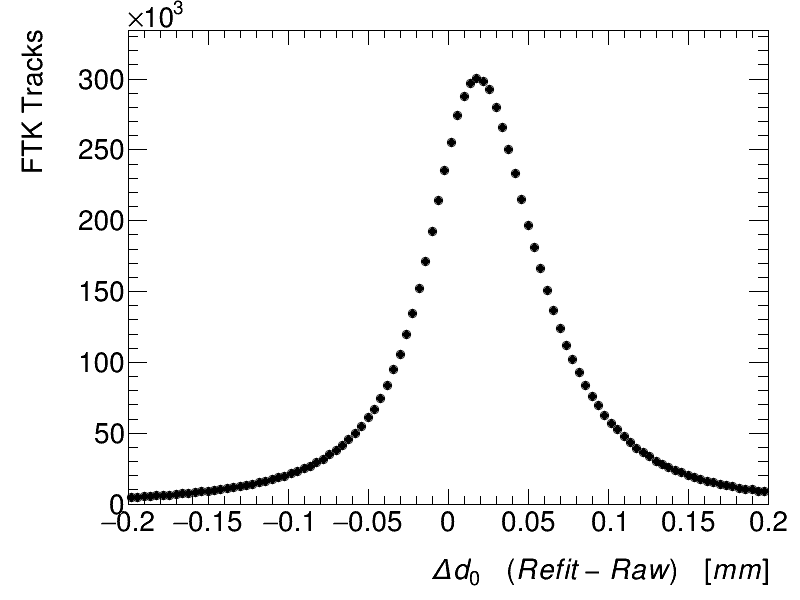

In [9]:
canvas = Canvas()
draw(hist_d0, xtitle="\Delta d_{0} \;\;\; (Refit - Raw) \;\;\; [mm]", ytitle="FTK Tracks")
canvas

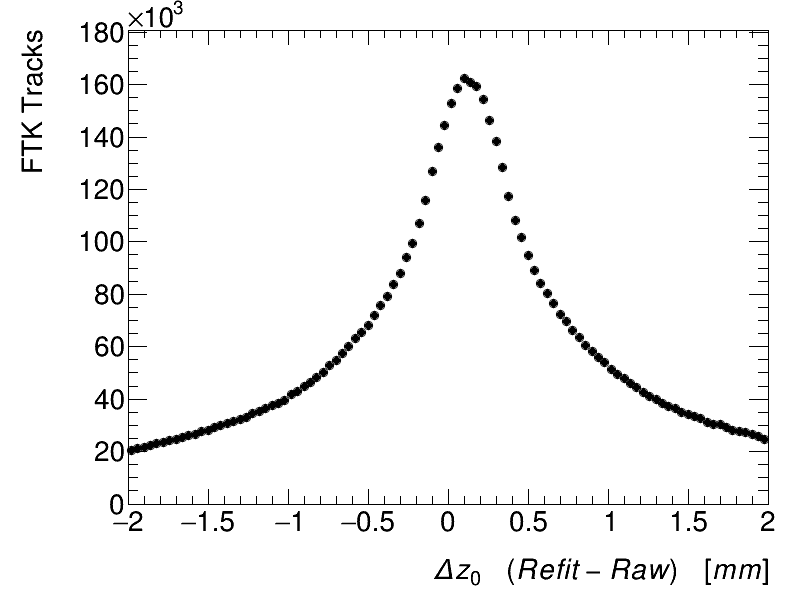

In [10]:
canvas = Canvas()
draw(hist_z0, xtitle="\Delta z_{0} \;\;\; (Refit - Raw) \;\;\; [mm]", ytitle="FTK Tracks")
canvas

# Plot all track parameters (truth, offline, raw and refit FTK)

In [77]:
from matplotlib.ticker import MaxNLocator

def plot_variable_grid(arr, ncol=4, nbins=50):
    nrow = (len(arr.dtype.names) - 1) / ncol + 1
    fig, axarr = plt.subplots(nrow, ncol, figsize=(ncol * 4, nrow * 4))
    for idx, name in enumerate(sorted(arr.dtype.names)):
        i = idx / ncol
        j = idx - i * ncol
        axarr[i, j].set_xlabel(name)
        # remove NaN and infinity
        variable = arr[name][~np.isnan(arr[name]) & ~np.isinf(arr[name])]
        # check if integral
        integral = np.issubdtype(variable.dtype, np.integer)
        low, high = variable.min(), variable.max()
        if low == high:
            bins = np.linspace(variable[0] - 1.5, variable[0] + 1.5, 4)
        elif integral:
            bins = np.linspace(low - .5, high + .5, min((high - low) + 2, 50))
        else:
            bins = nbins
        bins, edges = np.histogram(variable, bins)
        axarr[i, j].step(np.lib.pad(edges, (1, 0), 'edge'),
                         np.lib.pad(bins, (1, 1), 'constant', constant_values=[0, 0]),
                         where='post', color='black')
        axarr[i, j].ticklabel_format(style='sci', scilimits=(-3, 4), axis='both')
        if variable.std() < 0.1 * (high - low):
            axarr[i, j].set_yscale('log')
        if integral:
            axarr[i, j].get_xaxis().set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### Truth track parameters

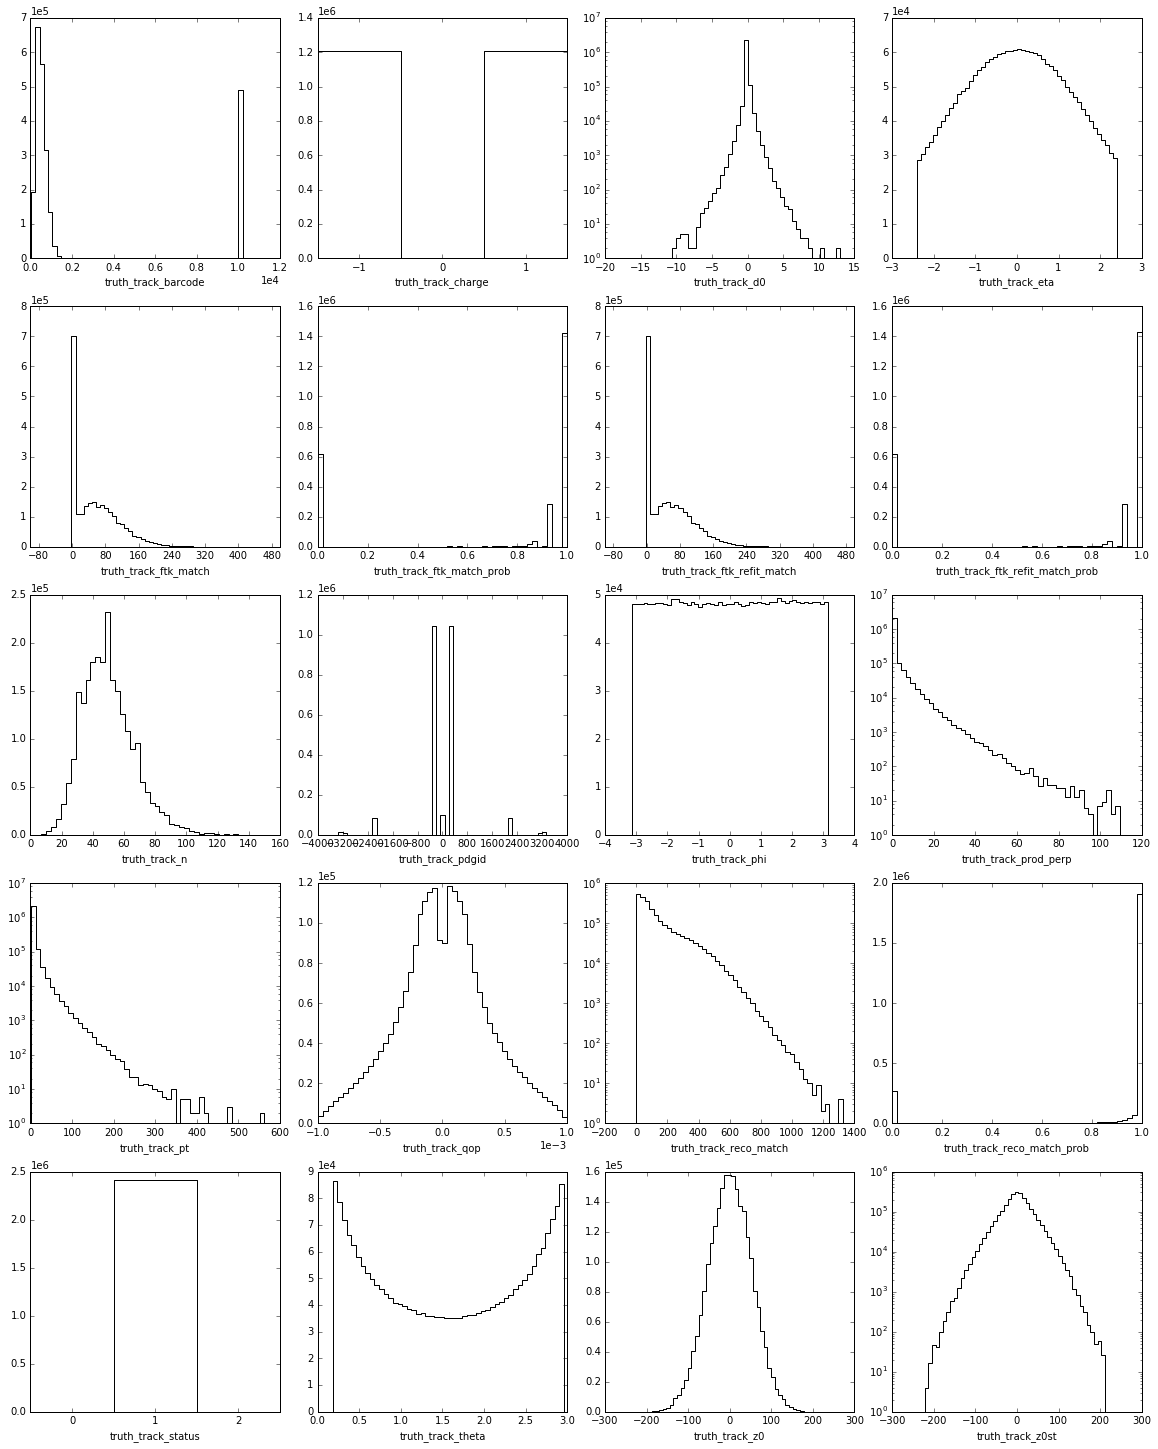

In [68]:
tree = root_open('tracks.root')['tracks']
truth_branches = [b for b in tree.branchnames if b.startswith('truth_')]
truth_arr = stretch(tree2array(tree, branches=truth_branches))
plot_variable_grid(truth_arr)
del truth_arr

### Offline reco track parameters

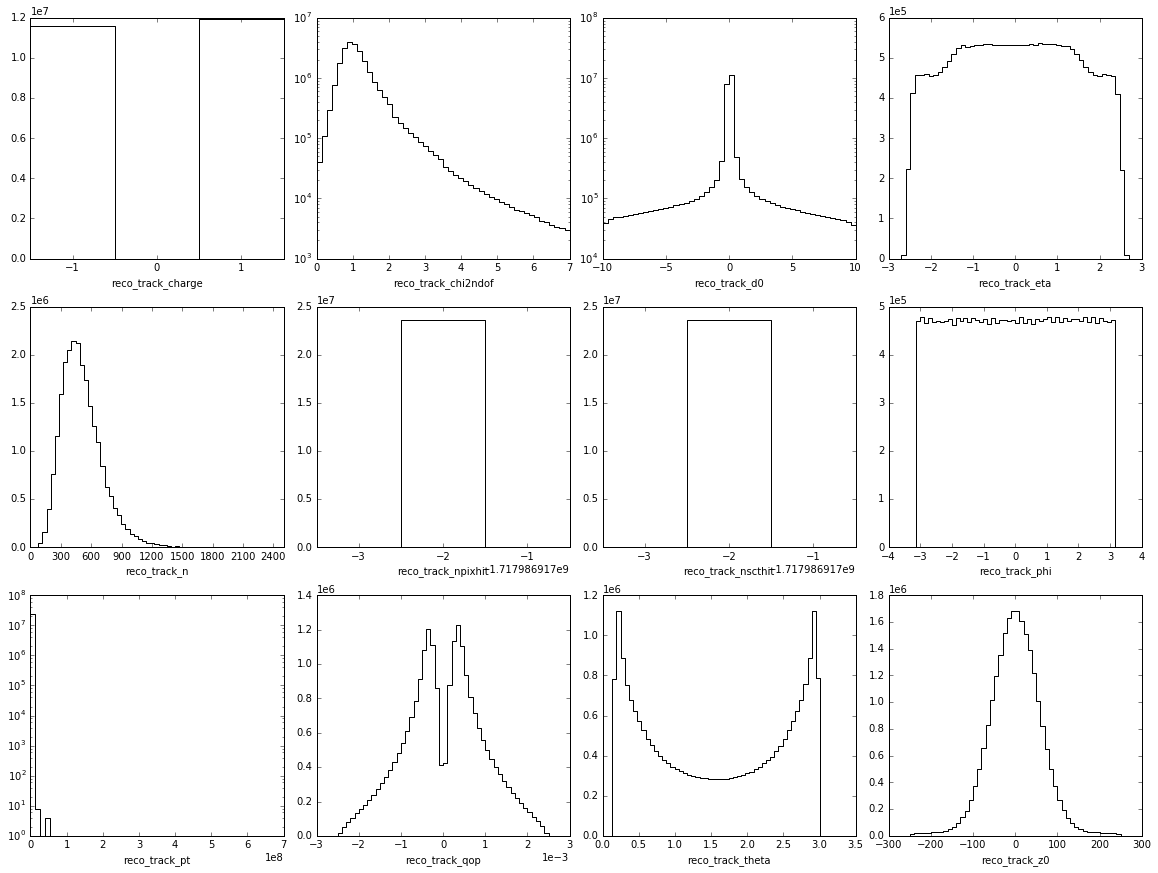

In [69]:
reco_branches = [b for b in tree.branchnames if b.startswith('reco_')]
reco_arr = stretch(tree2array(tree, branches=reco_branches))
plot_variable_grid(reco_arr)
del reco_arr

### FTK track parameters

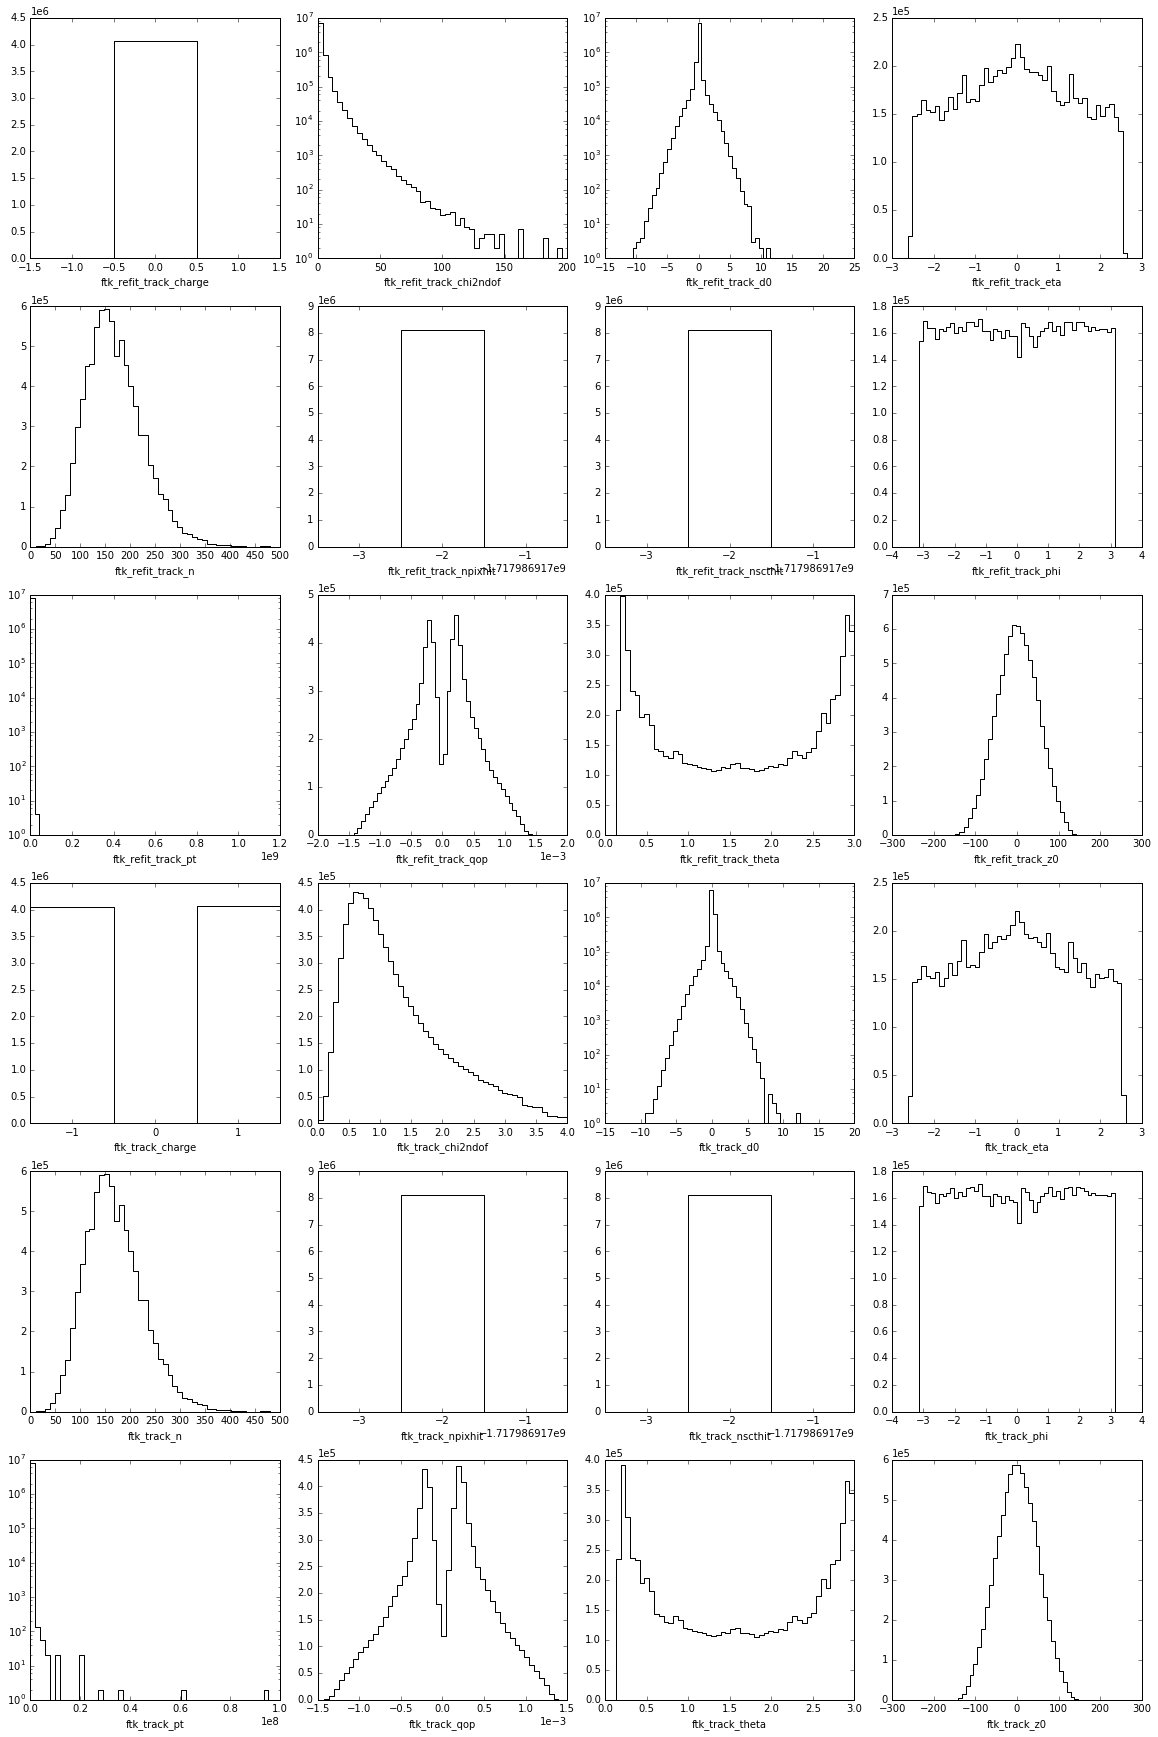

In [76]:
ftk_branches = [b for b in tree.branchnames if b.startswith('ftk_')]
ftk_arr = stretch(tree2array(tree, branches=ftk_branches))
plot_variable_grid(ftk_arr)
del ftk_arr